# Final Project: Choosing My NYC Neighborhood

In [1]:
#import libraries
import folium
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

In [4]:
# CLIENT_ID  your Foursquare ID
# CLIENT_SECRET  # your Foursquare Secret
# VERSION 

In [6]:
#get NY neighborhoods data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# fill it up
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
#save data offline
neighborhoods.to_csv('neigborhoods.csv')      

# I know I want to be by lots of sushi and pizza...

In [8]:
#defining necessary venue CategoryIDs from Foursquare
endpoint = 'https://api.foursquare.com/v2/venues/search?'

"""Category IDs:::: 
Pizza Place 4bf58dd8d48988d1ca941735, 
Sushi Restaurant 4bf58dd8d48988d1d2941735 """

categoryIDs = [ '4bf58dd8d48988d1d2941735', '4bf58dd8d48988d1ca941735']


categoryId = ','.join(categoryIDs)
limit = 1000

In [9]:
#def createURL function 
def createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit):
    url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            endpoint,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            limit
        )
    return url

In [10]:
#def nearby venues function
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=1000):
    endpoint = 'https://api.foursquare.com/v2/venues/search?'
    venues_list = []   
    
    for hood_name, lat, lng in zip(neighborhoods, latitudes, longitudes):
    
        url = createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit)
        
        results = requests.get(url).json()['response']['venues']

        for item in results:
            venue_name = item['name']
            venue_category = item['categories'][0]['name']
            venue_lat = item['location']['lat']
            venue_lng = item['location']['lng']
            try:
                venue_city = item['location']['city']
            except:
                venue_city = 'N/A'
            venue_state = item['location']['state']
            
            venues_list.append([(hood_name,
                                lat,
                                lng,
                                venue_name,
                                venue_category,
                                venue_lat,
                                venue_lng,
                                venue_city,
                                venue_state
                               )])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue Name',
                             'Venue Category',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue City',
                             'Venue State'
                            ]
    return nearby_venues

prelim_venue_data = getNearbyVenues(neighborhoods['Neighborhood'],
                                         neighborhoods['Latitude'],
                                         neighborhoods['Longitude']
                                        )

#save data offline
prelim_venue_data.to_csv('Final_Project_test.csv')  

# Count up our results by neighborhood...

In [11]:
#venue category counts
df_testx = pd.read_csv('Final_Project_test.csv', delimiter = ',')
venue_category_onehot = pd.get_dummies(df_testx[['Venue Category']], prefix="", prefix_sep="")
venue_category_onehot['Neighborhood'] = df_testx['Neighborhood'] 

fixed_columns = [venue_category_onehot.columns[-1]] + list(venue_category_onehot.columns[:-1])
venue_category_onehot = venue_category_onehot[fixed_columns]

venue_counts = venue_category_onehot.groupby('Neighborhood').sum()

venue_counts.to_csv('venue_counts.csv')  

venue_counts.head()

,American Restaurant,Arcade,Arepa Restaurant,Asian Restaurant,Bagel Shop,Bakery,Bar,Boat or Ferry,Brazilian Restaurant,Breakfast Spot,...,Sandwich Place,Seafood Restaurant,Snack Place,Spanish Restaurant,Sports Bar,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Annadale,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
Arden Heights,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
Arlington,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Use feature scaling to compare our metrics...

In [12]:
#feature scaled as an index
pizza = venue_counts.loc[: , "Pizza Place"]
pizza_fscaled = round(pizza/pizza.max(),2)
pizza_40 = pizza_fscaled.nlargest(40)
pizza_40.head()

Neighborhood
Kingsbridge Heights    1.00
Fordham                0.91
East Harlem            0.89
Bedford Stuyvesant     0.87
Jackson Heights        0.87
Name: Pizza Place, dtype: float64

In [13]:
#feature scaled as an index
sushi = venue_counts.loc[: , "Sushi Restaurant"]
sushi_fscaled = round(sushi/sushi.max(),2)
sushi_40 = sushi_fscaled.nlargest(40)
sushi_40.head()  

Neighborhood
Roosevelt Island    1.00
Upper East Side     0.90
Tudor City          0.85
Yorkville           0.85
Murray Hill         0.80
Name: Sushi Restaurant, dtype: float64

# Since I've observed Sushi is harder come by than Pizza...

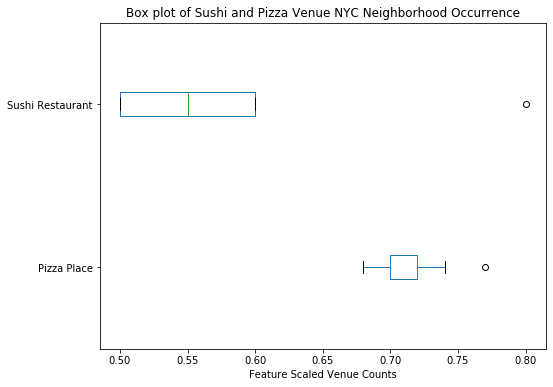

In [16]:
nyc_results.plot(kind='box', figsize=(8, 6), vert=False)

plt.title('Box plot of Sushi and Pizza Venue NYC Neighborhood Occurrence')
plt.xlabel('Feature Scaled Venue Counts')

plt.show()

# I'll prioritize the sort by Sushi venues, then Pizza...

In [15]:
nyc_results = pd.merge(pizza_40, sushi_40,  on='Neighborhood').sort_values(['Sushi Restaurant', 'Pizza Place'], ascending=[False, False])
nyc_results


,Pizza Place,Sushi Restaurant
Neighborhood,,
Murray Hill,0.77,0.80
Gramercy,0.70,0.60
East Village,0.68,0.60
Bensonhurst,0.72,0.55
Lefrak City,0.72,0.55
Ocean Parkway,0.72,0.55
Fort Greene,0.74,0.50
Downtown,0.72,0.50
Brooklyn Heights,0.70,0.50


In [ ]:
nyc_box = pd.merge(pizza__fscaled, sushi__fscaled,  on='Neighborhood').sort_values(['Sushi Restaurant', 'Pizza Place'], ascending=[False, False])
nyc_box.plot(kind='box', figsize=(8, 6), vert=False)


# Wow...it's looking like I'll prioritize my real estate search starting in Murray Hill!

In [112]:
results = pd.merge(neighborhoods, pizza_40,  on='Neighborhood')
nyc_results_w_geo = round(pd.merge(results, sushi_40,  on='Neighborhood'),2).sort_values(['Sushi Restaurant', 'Pizza Place'], ascending=[False, False]).set_index('Neighborhood')
nyc_results_w_geo = nyc_results_w_geo.drop(columns=['Borough'])
nyc_results_w_geo.to_csv('nyc_results_w_geo.csv')  

nyc_results_w_geo.head()



,Latitude,Longitude,Pizza Place,Sushi Restaurant
Neighborhood,,,,
Murray Hill,40.75,-73.98,0.77,0.80
Murray Hill,40.76,-73.81,0.77,0.80
Gramercy,40.74,-73.98,0.70,0.60
East Village,40.73,-73.98,0.68,0.60
Bensonhurst,40.61,-74.00,0.72,0.55


# Right around here...

In [2]:
mmm = folium.Map(location=[40.7479, -73.9757], zoom_start=17) # Murray Hill latitude and longitude via Google...
folium.CircleMarker(location = [40.7479, -73.9757 ], radius = 200, popup = 'Murray Hill').add_to(mmm)
mmm

# the End.